In [1]:
import torch
import numpy as np
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch import nn

from models import Generator_28, Discriminator_28, CNN_MNIST

device = 'cuda'


In [2]:
# fname = './models/DCGAN_conditional_MNIST_weights_20211208_1741.pth'
# fname = './models/DCGAN_conditional_corrupted_MNIST_weights_20211208_1800.pth'
fname = './models/DCGAN_corrupted_MNIST_weights_20211208_1838.pth'
conditional = True if 'conditional' in fname else False

z_dim = 64
n_classes = 10 if conditional else 0
generator_input_dim = z_dim + n_classes

gen = Generator_28(generator_input_dim).to(device)
gen.load_state_dict(torch.load(fname))
gen.eval()

Generator_28(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)

## Interpolate between 2 samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


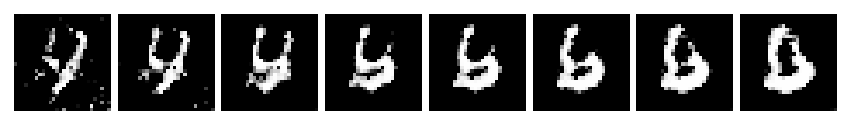

In [3]:
noise_1 = torch.randn(1, z_dim, 1, 1, device=device)
noise_2 = torch.randn(1, z_dim, 1, 1, device=device)
images = []
label = torch.tensor([3])

for alpha in np.linspace(0, 1, num=8):
    noise = (1-alpha)*noise_1 + alpha*noise_2
    if conditional:
        one_hot_labels = nn.functional.one_hot(label.to(device), n_classes)[:,:,None,None]
        noise = torch.cat((noise.float(), one_hot_labels.float()), dim=1)
    with torch.no_grad():
        fake = gen(noise).detach().cpu()
    images.append(fake)

images = torch.cat(images, 0)
vutils.make_grid(images).permute(1,2,0)

plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(vutils.make_grid(images, pad_value=1, nrow=8).permute(1,2,0))

## Find noise direction

In [4]:
# load noise classifier
fname = './models/CNN_noise_MNIST_weights_20211216_1613.pth'
noise_predictor = CNN_MNIST(output_dim=6).to(device)
noise_predictor.load_state_dict(torch.load(fname))

# generate batch of images and get their noise level
noise = torch.randn(10000, z_dim, 1, 1, device=device)
if conditional:
    label = torch.randint(n_classes, size=(len(noise),), dtype=int)
    one_hot_labels = nn.functional.one_hot(label.to(device), n_classes)[:,:,None,None]
    noise = torch.cat((noise.float(), one_hot_labels.float()), dim=1)
with torch.no_grad():
    fake = gen(noise).detach()
    predictions = noise_predictor(fake).detach().cpu()
predicted_labels = np.argmax(predictions, 1)

# keep latent codes of images with noise = 1 and 5
z_noise_low = noise[predicted_labels == 1].squeeze()
z_noise_high = noise[predicted_labels == 5].squeeze()

avg_z_noise_low = torch.mean(z_noise_low, axis=0)
avg_z_noise_high = torch.mean(z_noise_high, axis=0)

# average of latent codes for noisy - average of latent codes for uncorrupted
noise_direction = avg_z_noise_high - avg_z_noise_low
if conditional: 
    # noise_direction = torch.cat((noise_direction[:z_dim], torch.zeros((10,), device=device)))
    noise_direction = noise_direction[:z_dim] # don't keep class information

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


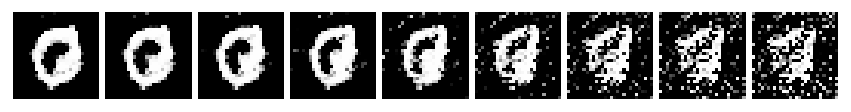

In [5]:
# truncation_threshold = 10 # https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/12
# noise_start = torch.fmod(torch.randn(1, z_dim, 1, 1, device=device), truncation_threshold)
noise_start = torch.randn(1, z_dim, 1, 1, device=device)
images = []
label = torch.tensor([8])

for alpha in np.linspace(-1, 1, num=9):
    noise = noise_start + alpha*noise_direction[None, :, None, None]
    if conditional:
        one_hot_labels = nn.functional.one_hot(label.to(device), n_classes)[:,:,None,None]
        noise = torch.cat((noise.float(), one_hot_labels.float()), dim=1)
    with torch.no_grad():
        fake = gen(noise).detach().cpu()
    images.append(fake)

images = torch.cat(images, 0)
vutils.make_grid(images).permute(1,2,0)

plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(vutils.make_grid(images, pad_value=1, nrow=9).permute(1,2,0))